### Import Libraries
Import the relevant libraries used for the analysis

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import re

### Read the Airbnb data

The Airbnb data set for Toronto was obtained from http://insideairbnb.com/get-the-data.html

In [2]:
data = pd.read_csv("listings.csv")
display(data.head())
display(data.shape)

id                                         name  host_id  \
0   1419              Beautiful home in amazing area!     1565   
1   8077           Downtown Harbourfront Private Room    22795   
2  12604               Seaton Village Parlour Bedroom    48239   
3  23691              Queen Bedroom close to downtown    93825   
4  27423  Executive Studio Unit- Ideal for One Person   118124   

        host_name  neighbourhood_group                      neighbourhood  \
0       Alexandra                  NaN                    Little Portugal   
1  Kathie & Larry                  NaN  Waterfront Communities-The Island   
2            Rona                  NaN                              Annex   
3   Yohan & Sarah                  NaN               Briar Hill-Belgravia   
4           Brent                  NaN                  Greenwood-Coxwell   

   latitude  longitude        room_type  price  minimum_nights  \
0  43.64617  -79.42451  Entire home/apt    469               4   
1  43.64105  -79.37628     Private room     96             180   
2  43.66724  -79.41598     Private room     64               1   
3  43.69602  -79.45468     Private room     70               1   
4  43.66890  -79.32592  Entire home/apt     45             365   

   number_of_reviews last_review  reviews_per_month  \
0                  7  2017-12-04               0.11   
1                169  2013-08-27               1.22   
2                  0         NaN                NaN   
3                217  2019-12-22               1.68   
4                 26  2011-08-30               0.20   

   calculated_host_listings_count  availability_365  
0                               1                 0  
1                               2               365  
2                               1                 0  
3                               2               324  
4                               1                 0

(18265, 16)

### Exploratory data analysis
Let's check for the missing values in the above data set and perform some preliminary exploratory analysis

In [3]:
display(pd.DataFrame({'Missing Values':data.isna().sum(),'Percentage':data.isna().sum()*100/data.shape[0]}))

Missing Values  Percentage
id                                           0    0.000000
name                                         1    0.005475
host_id                                      0    0.000000
host_name                                   11    0.060224
neighbourhood_group                      18265  100.000000
neighbourhood                                0    0.000000
latitude                                     0    0.000000
longitude                                    0    0.000000
room_type                                    0    0.000000
price                                        0    0.000000
minimum_nights                               0    0.000000
number_of_reviews                            0    0.000000
last_review                               4105   22.474678
reviews_per_month                         4105   22.474678
calculated_host_listings_count               0    0.000000
availability_365                             0    0.000000

As seen in the table above, the column "neighbourhood_group" is an empty column and hence can be deleted. Additionaly, we have one missing value in the "name" column, 11 in "host_name", 4105 in "last_review" and "reviews_per_month". Let's not delete any of these rows for now.

In [4]:
data.drop(['neighbourhood_group'],axis=1,inplace=True)
display(data.head())

id                                         name  host_id  \
0   1419              Beautiful home in amazing area!     1565   
1   8077           Downtown Harbourfront Private Room    22795   
2  12604               Seaton Village Parlour Bedroom    48239   
3  23691              Queen Bedroom close to downtown    93825   
4  27423  Executive Studio Unit- Ideal for One Person   118124   

        host_name                      neighbourhood  latitude  longitude  \
0       Alexandra                    Little Portugal  43.64617  -79.42451   
1  Kathie & Larry  Waterfront Communities-The Island  43.64105  -79.37628   
2            Rona                              Annex  43.66724  -79.41598   
3   Yohan & Sarah               Briar Hill-Belgravia  43.69602  -79.45468   
4           Brent                  Greenwood-Coxwell  43.66890  -79.32592   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    469               4                  7  2017-12-04   
1     Private room     96             180                169  2013-08-27   
2     Private room     64               1                  0         NaN   
3     Private room     70               1                217  2019-12-22   
4  Entire home/apt     45             365                 26  2011-08-30   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.11                               1                 0  
1               1.22                               2               365  
2                NaN                               1                 0  
3               1.68                               2               324  
4               0.20                               1                 0

## Calculate the distance traveled

We can include a new column that shows the distance between a central point to the location of the AirBnB (I have chosen Nathan Philips Square)

The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br> Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

In [5]:
def haversine_distance(data,lat1='latitude',long1='longitude', lat2=43.65319, long2=-79.38147):
    
    r = 6371
       
    phi1 = np.radians(data[lat1])
    phi2 = np.radians(lat2)
    
    delta_phi = np.radians(lat2-data[lat1])
    delta_lambda = np.radians(long2-data[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
data['distance_km'] = haversine_distance(data)
display(data.head())

id                                         name  host_id  \
0   1419              Beautiful home in amazing area!     1565   
1   8077           Downtown Harbourfront Private Room    22795   
2  12604               Seaton Village Parlour Bedroom    48239   
3  23691              Queen Bedroom close to downtown    93825   
4  27423  Executive Studio Unit- Ideal for One Person   118124   

        host_name                      neighbourhood  latitude  longitude  \
0       Alexandra                    Little Portugal  43.64617  -79.42451   
1  Kathie & Larry  Waterfront Communities-The Island  43.64105  -79.37628   
2            Rona                              Annex  43.66724  -79.41598   
3   Yohan & Sarah               Briar Hill-Belgravia  43.69602  -79.45468   
4           Brent                  Greenwood-Coxwell  43.66890  -79.32592   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    469               4                  7  2017-12-04   
1     Private room     96             180                169  2013-08-27   
2     Private room     64               1                  0         NaN   
3     Private room     70               1                217  2019-12-22   
4  Entire home/apt     45             365                 26  2011-08-30   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.11                               1                 0   
1               1.22                               2               365   
2                NaN                               1                 0   
3               1.68                               2               324   
4               0.20                               1                 0   

   distance_km  
0     3.549788  
1     1.413022  
2     3.185518  
3     7.572856  
4     4.797892

In [7]:
price_stat = pd.DataFrame(data['price'].describe())
display(price_stat)

price
count  18265.000000
mean     137.659677
std      306.423241
min        0.000000
25%       60.000000
50%       95.000000
75%      149.000000
max    13000.000000

From the above table, we can observe the minimum value for the price to be zero. We can take a look at these entries and decide to look up the actual price or just delete the entry.

In [8]:
display(data[data['price']==0])

id                                              name    host_id  \
15413  42738772           Residence & Conference Centre - Toronto  332023628   
15793  43309343  Residence & Conference Centre - Toronto Downtown  316829844   

                           host_name                      neighbourhood  \
15413                            Rcc                  Hillcrest Village   
15793  Residence & Conference Centre  Waterfront Communities-The Island   

       latitude  longitude   room_type  price  minimum_nights  \
15413  43.79633  -79.34674  Hotel room      0               1   
15793  43.65444  -79.35632  Hotel room      0               1   

       number_of_reviews last_review  reviews_per_month  \
15413                  0         NaN                NaN   
15793                  0         NaN                NaN   

       calculated_host_listings_count  availability_365  distance_km  
15413                               1                 0    16.159260  
15793                               1                 0     2.028141

A simple google search showed me that it costs about 75 dollars per night at RCC. We set the price for the above two listings to be 75.

In [9]:
data.loc[data['price']==0,'price'] = 75

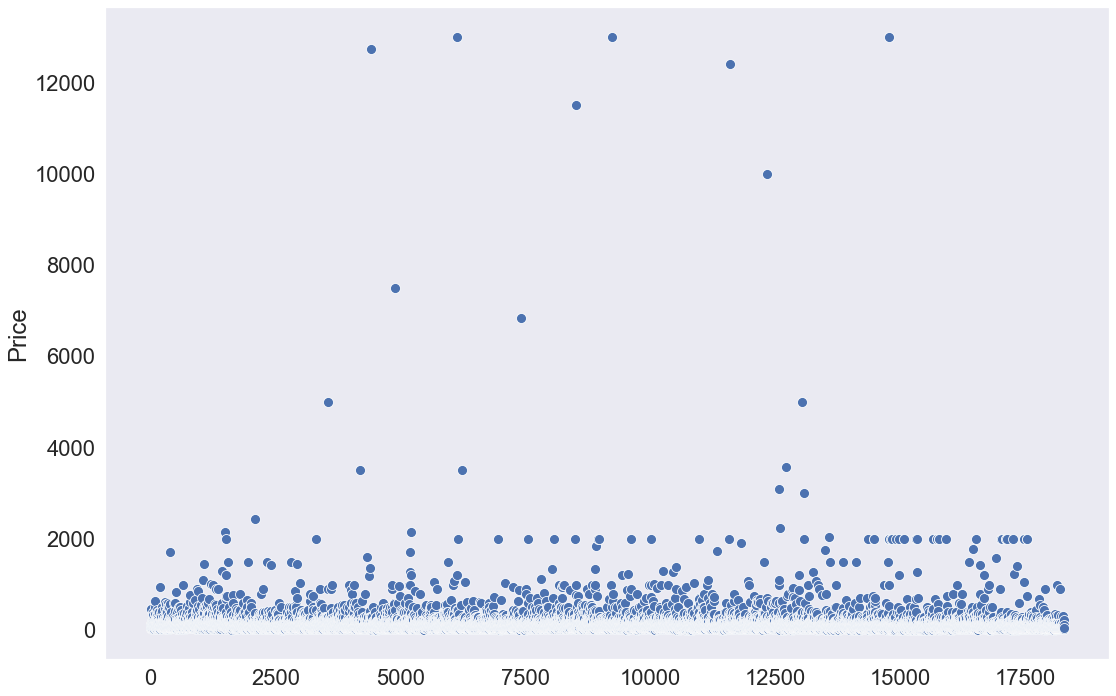

In [10]:
sns.set(font_scale=2,rc={'figure.figsize':(18,12)})
ax = sns.scatterplot(x=data.index,y=data['price'],s=100);
ax.set(ylabel='Price')
ax.grid(False);

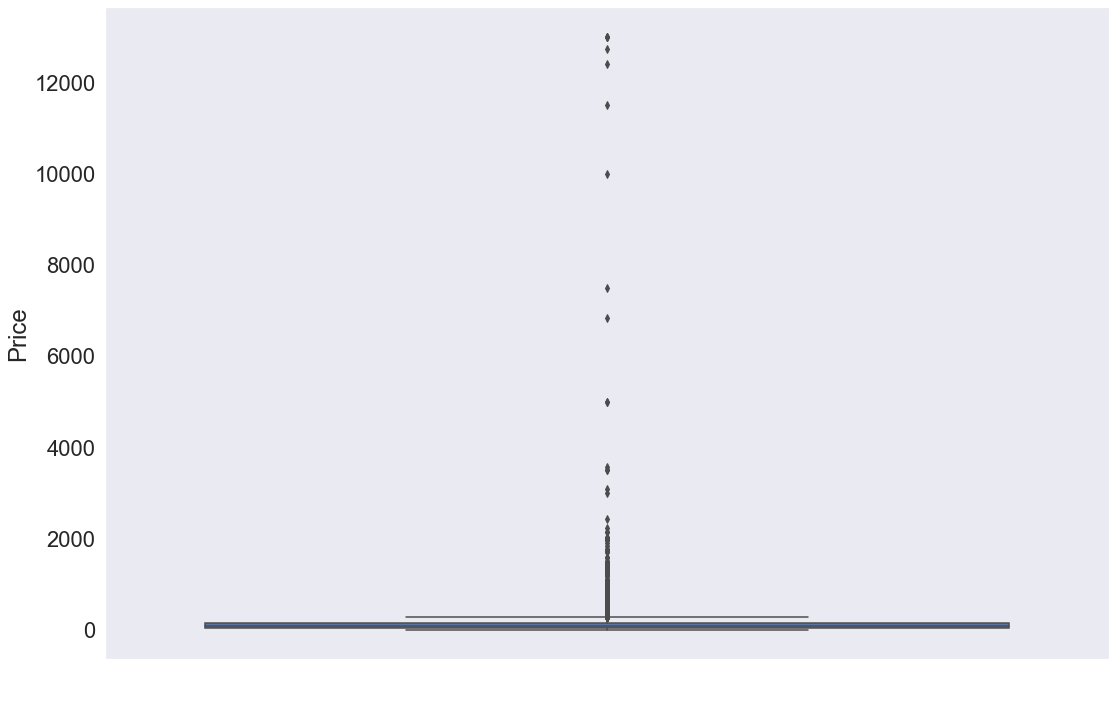

In [11]:
ax = sns.boxplot(y='price',  data=data)
ax.set(xlabel = ' ',ylabel='Price')
ax.grid(False);

The scatter plot and box plot reveal a lot of outliers to be present. In our case outliers are high priced rooms. Upon further investigation, I found some of the rooms to be highly priced, while some other rooms have reported prices for multiple nights and hence standing out. Some of the listings have a component of "art" attached to them, making it pricey.
We can take a quick look at the location of these luxury listings and remove them from our data set.

In [12]:
upper_lim_price = float(price_stat.iloc[6] + 1.5*(price_stat.iloc[6] - price_stat.iloc[4]))
outlier_data = data[data['price']>upper_lim_price]
display(outlier_data.head())
display(outlier_data.shape)

id                                               name  host_id  \
0     1419                    Beautiful home in amazing area!     1565   
53  228568                BEST VIEW in the City! Luxury condo   934821   
54  229913                 Upscale 2bed Downtown Toronto-lake  1200620   
79  361599  Luxury House in Downtown For 12people+  6 parking   174063   
82  366973                Spacious Modern Cozy King W Toronto  1015670   

    host_name                      neighbourhood  latitude  longitude  \
0   Alexandra                    Little Portugal  43.64617  -79.42451   
53        Rob                North St.James Town  43.66771  -79.37679   
54     Sergei                            Niagara  43.63479  -79.39957   
79      Denis                     South Parkdale  43.63737  -79.43939   
82      Grace  Waterfront Communities-The Island  43.64341  -79.40046   

          room_type  price  minimum_nights  number_of_reviews last_review  \
0   Entire home/apt    469               4                  7  2017-12-04   
53  Entire home/apt    400              28                 56  2020-09-06   
54  Entire home/apt    325              60                 10  2017-08-26   
79  Entire home/apt    500              30                  0         NaN   
82  Entire home/apt    361               3                  9  2017-09-12   

    reviews_per_month  calculated_host_listings_count  availability_365  \
0                0.11                               1                 0   
53               0.51                               2               278   
54               0.11                               1                 1   
79                NaN                               5                 0   
82               0.11                               1               363   

    distance_km  
0      3.549788  
53     1.657862  
54     2.511420  
79     4.981391  
82     1.875417

(1200, 16)

### Read the geoJSON neighbourhood data

In [13]:
count = data.groupby(['neighbourhood']).size().reset_index(name='count')
display(count.head())

neighbourhood  count
0               Agincourt North     38
1  Agincourt South-Malvern West    104
2                     Alderwood     23
3                         Annex    586
4             Banbury-Don Mills     54

In [14]:
neigh_data = gpd.read_file('neighbourhoods.geojson')
neigh_data.drop(['neighbourhood_group'],axis=1,inplace=True)
display(neigh_data.head())

geo_data = neigh_data.merge(count,on='neighbourhood')
display(geo_data.head())

neighbourhood                                           geometry
0  York University Heights  MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...
1              The Beaches  MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ...
2      Scarborough Village  MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ...
3           South Parkdale  MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ...
4          South Riverdale  MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ...

neighbourhood                                           geometry  \
0  York University Heights  MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...   
1              The Beaches  MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ...   
2      Scarborough Village  MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ...   
3           South Parkdale  MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ...   
4          South Riverdale  MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ...   

   count  
0    175  
1    151  
2     18  
3    299  
4    340

In [15]:
map_toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=11)

folium.Choropleth(geo_data = neigh_data,
                  data = count,
                  columns = ['neighbourhood','count'],
                  key_on = 'feature.properties.neighbourhood',
                  fill_color='BuPu',
                  fill_opacity=0.8, 
                  line_opacity=1,
                  legend_name='Covid cases by FSA').add_to(map_toronto)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0, 
                            'weight': 1}

interac_feat = folium.features.GeoJson(data = geo_data,
                                       style_function = style_function,
                                       control = False,
                                       tooltip = folium.features.GeoJsonTooltip(
                                       fields = ['neighbourhood','count'],
                                       aliases = ['Neighbourhood name: ', 'Number of listings: '],
                style=("background-color: white; color: #000000; font-family: arial; font-size: 15px; padding: 10px;")
                                       )
                                      )
               
    
map_toronto.add_child(interac_feat)
map_toronto.keep_in_front(interac_feat)
folium.LayerControl().add_to(map_toronto)


map_toronto

In [16]:
coord_list = outlier_data[['latitude','longitude']].values.tolist()

for coord in range(0, len(coord_list)):
    folium.Marker(coord_list[coord], popup=data['name'][coord]).add_to(map_toronto)

map_toronto

#### Remove the outlier data for further analysis

In [17]:
data.drop(data[data['price']>upper_lim_price].index,inplace=True)
display(data.head())
display(data.shape)

id                                         name  host_id  \
1   8077           Downtown Harbourfront Private Room    22795   
2  12604               Seaton Village Parlour Bedroom    48239   
3  23691              Queen Bedroom close to downtown    93825   
4  27423  Executive Studio Unit- Ideal for One Person   118124   
5  30931           Downtown Toronto - Waterview Condo    22795   

        host_name                      neighbourhood  latitude  longitude  \
1  Kathie & Larry  Waterfront Communities-The Island  43.64105  -79.37628   
2            Rona                              Annex  43.66724  -79.41598   
3   Yohan & Sarah               Briar Hill-Belgravia  43.69602  -79.45468   
4           Brent                  Greenwood-Coxwell  43.66890  -79.32592   
5  Kathie & Larry  Waterfront Communities-The Island  43.64151  -79.37643   

         room_type  price  minimum_nights  number_of_reviews last_review  \
1     Private room     96             180                169  2013-08-27   
2     Private room     64               1                  0         NaN   
3     Private room     70               1                217  2019-12-22   
4  Entire home/apt     45             365                 26  2011-08-30   
5  Entire home/apt    127             180                  1  2010-08-11   

   reviews_per_month  calculated_host_listings_count  availability_365  \
1               1.22                               2               365   
2                NaN                               1                 0   
3               1.68                               2               324   
4               0.20                               1                 0   
5               0.01                               2               365   

   distance_km  
1     1.413022  
2     3.185518  
3     7.572856  
4     4.797892  
5     1.360595

(17065, 16)

#### Stripplot for Room type vs Price

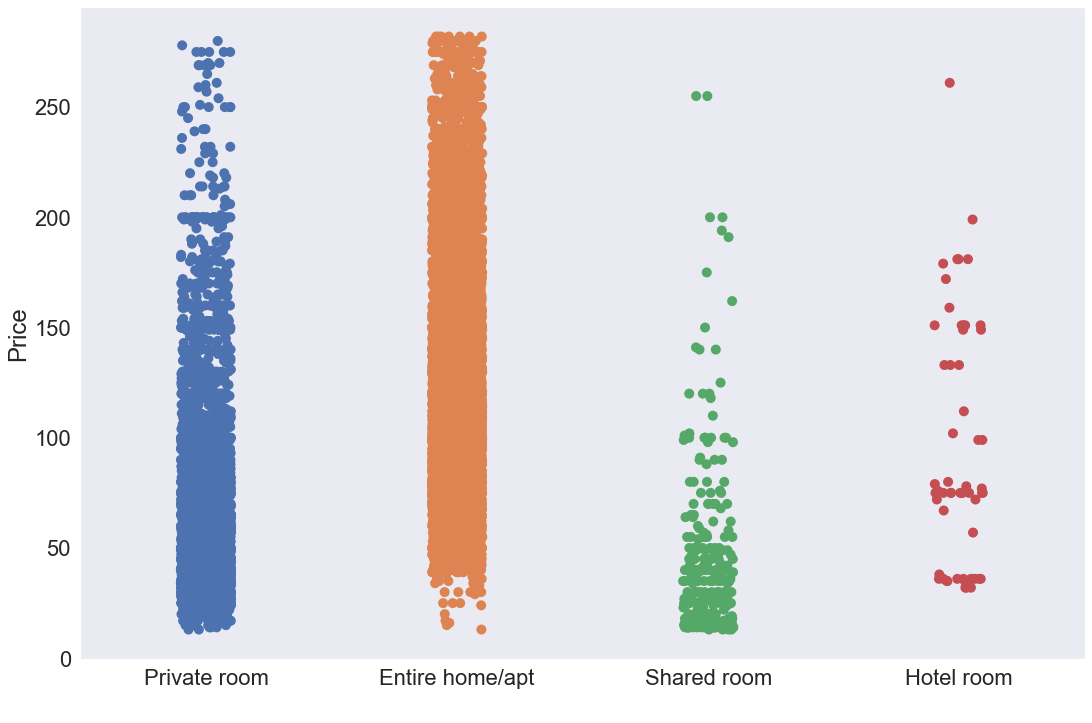

In [18]:
ax = sns.stripplot(x='room_type', y='price',data=data,s=10)
ax.set(xlabel = ' ',ylabel='Price')
ax.grid(False);

#### Box plot for Room type vs Price

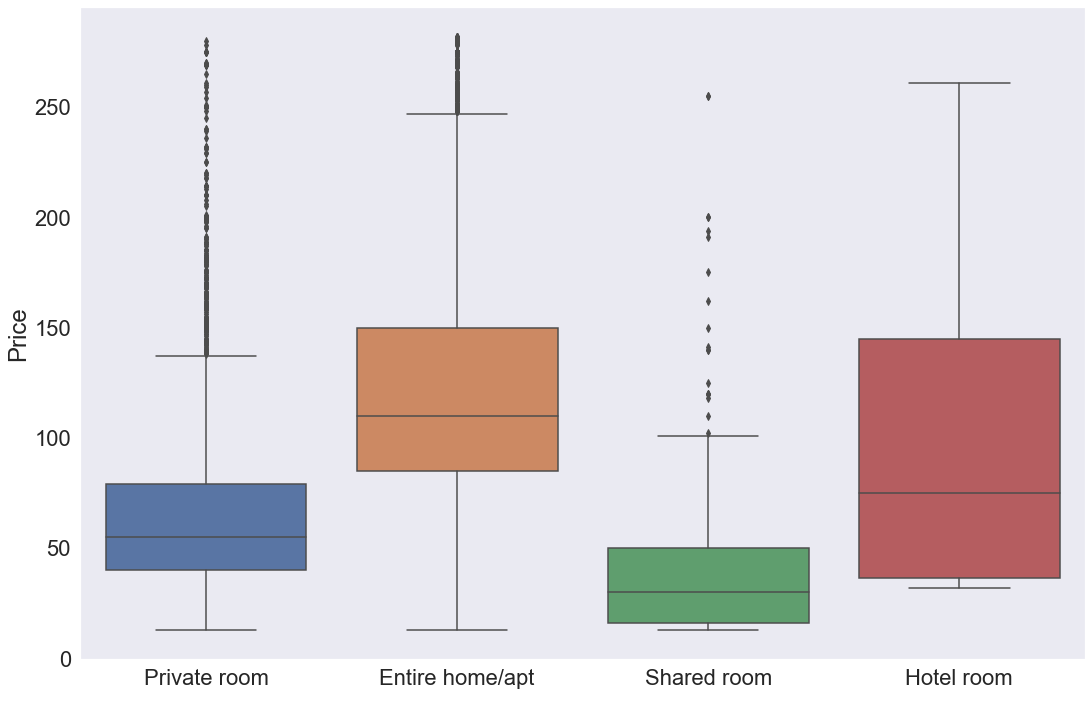

In [21]:
ax = sns.boxplot(x='room_type', y='price',  data=data)
ax.set(xlabel = ' ',ylabel='Price')
ax.grid(False);

#### Summary statistics for various room types

In [19]:
room_data = pd.DataFrame({'Entire Home/Apt':data.loc[data['room_type']=='Entire home/apt','price'].describe(), 
                      'Private Room':data.loc[data['room_type']=='Private room','price'].describe(),
                     'Shared Room':data.loc[data['room_type']=='Shared room','price'].describe(),
                     'Hotel Room':data.loc[data['room_type']=='Hotel room','price'].describe()})

display(room_data)

Entire Home/Apt  Private Room  Shared Room  Hotel Room
count     10455.000000   6250.000000   302.000000   58.000000
mean        123.492970     65.266400    42.745033   93.482759
std          52.055813     37.488078    39.011173   54.654655
min          13.000000     13.000000    13.000000   32.000000
25%          85.000000     40.000000    16.000000   36.500000
50%         110.000000     55.000000    30.000000   75.000000
75%         150.000000     79.000000    50.000000  145.000000
max         282.000000    280.000000   255.000000  261.000000

In [20]:
room_data_1 = pd.DataFrame({'Percentage':room_data.iloc[0]*100/data.shape[0]})

display(room_data_1)

Percentage
Entire Home/Apt   61.265749
Private Room      36.624670
Shared Room        1.769704
Hotel Room         0.339877

distance_km
count  17065.000000
mean       6.252060
std        5.509566
min        0.079531
25%        1.789859
50%        4.124298
75%        9.955797
max       25.765431

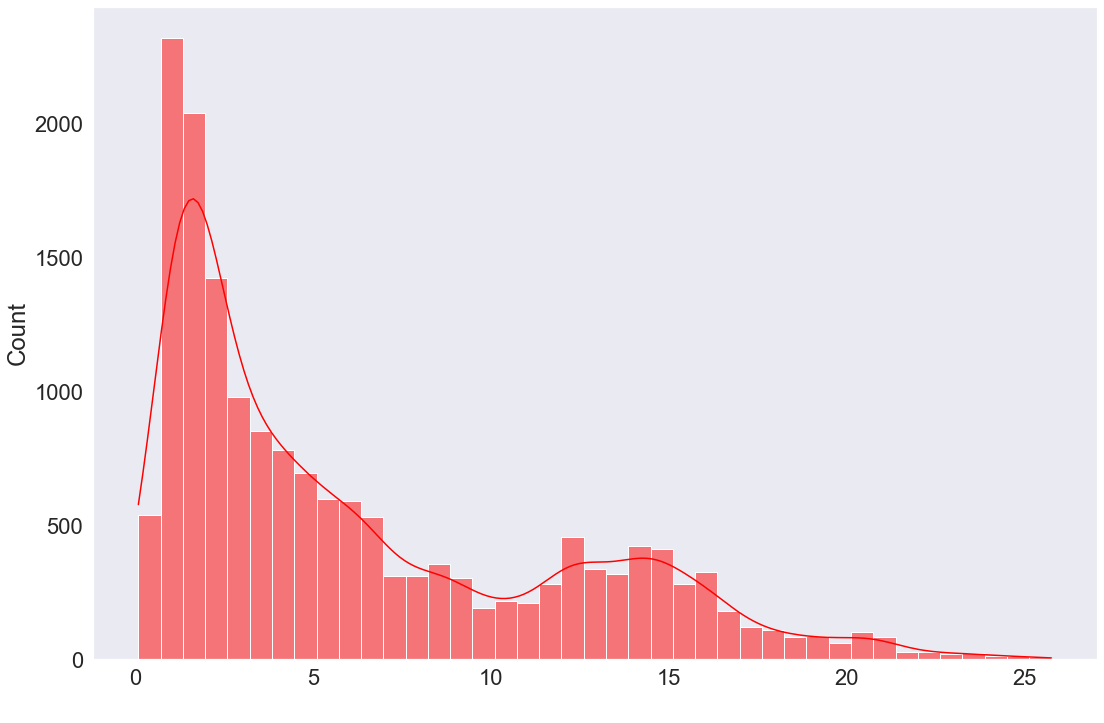

In [22]:
display(pd.DataFrame(data['distance_km'].describe()))
ax = sns.histplot( data['distance_km'], color="red", kde=True)
ax.set(ylabel='Count',xlabel=' ')
ax.grid(False);

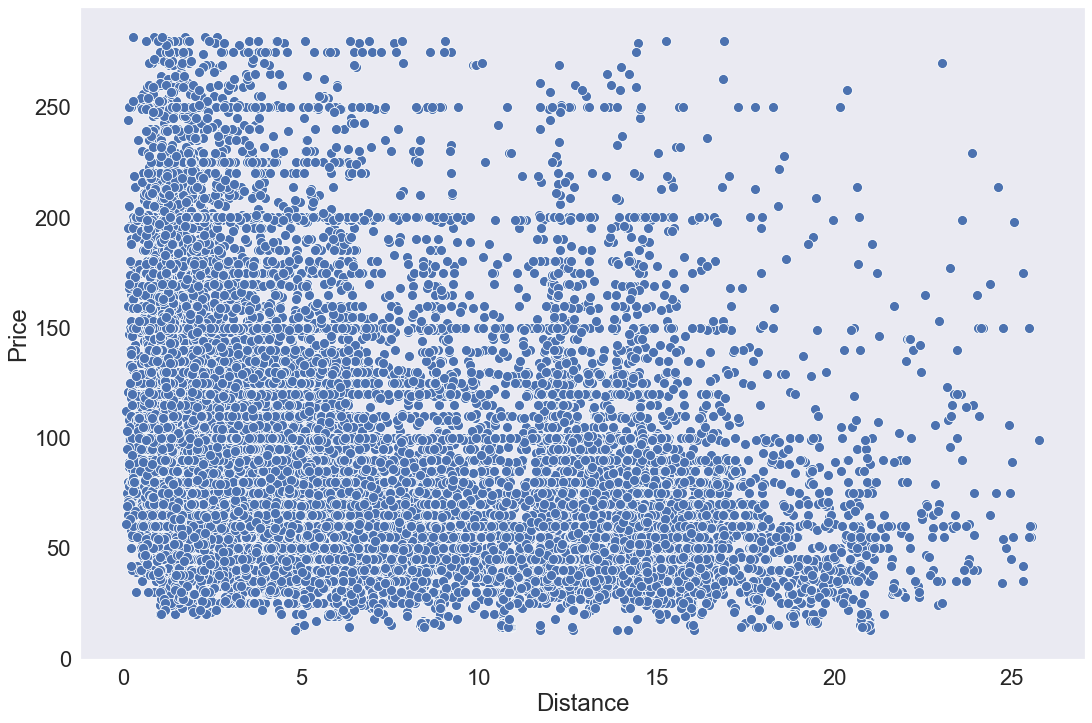

In [25]:
ax = sns.scatterplot(x='distance_km',y='price',data=data,s=100);
ax.set(ylabel='Price',xlabel='Distance')
ax.grid(False);

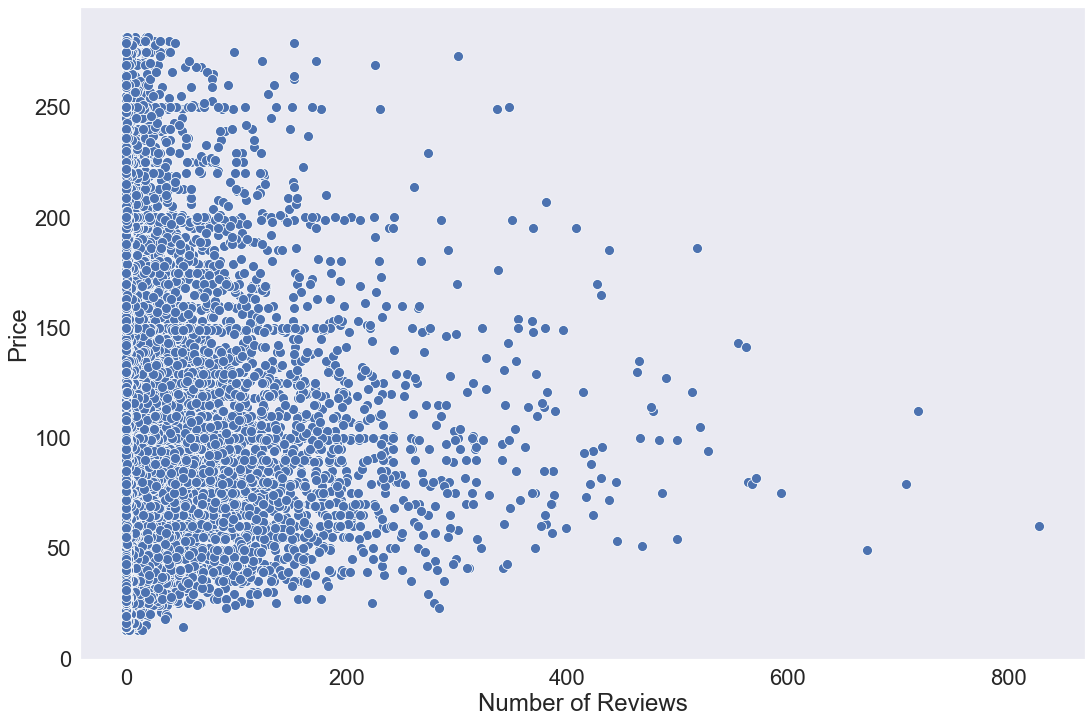

In [28]:
ax = sns.scatterplot(x='number_of_reviews',y='price',data=data,s=100);
ax.set(ylabel='Price',xlabel='Number of Reviews')
ax.grid(False);

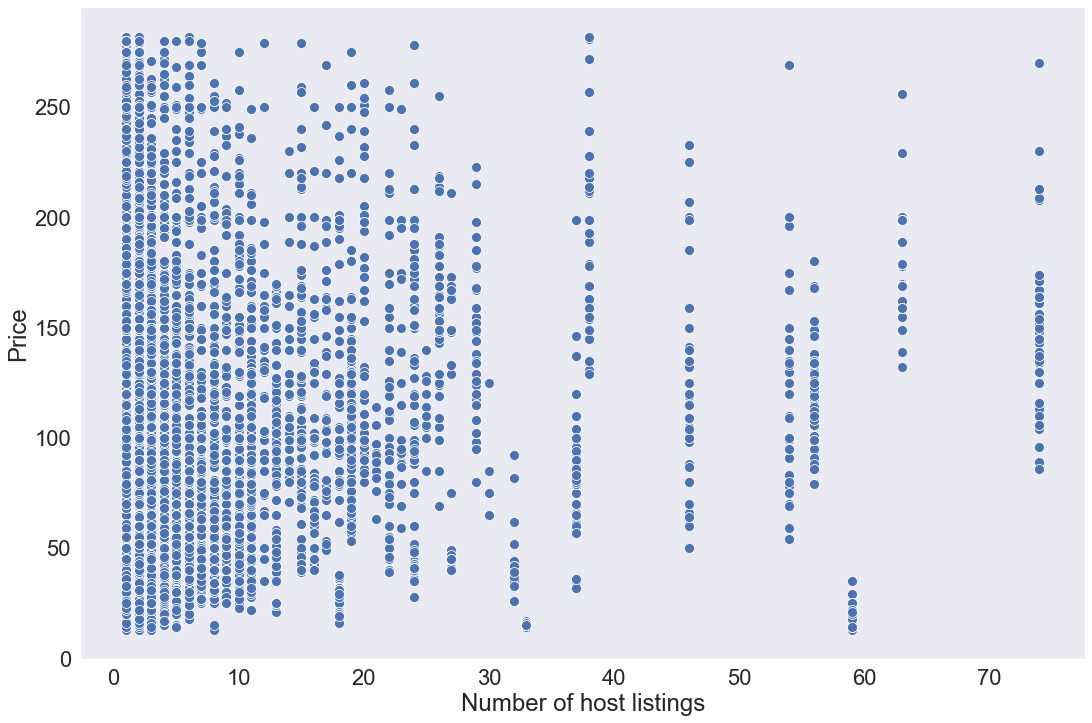

In [29]:
ax = sns.scatterplot(x='calculated_host_listings_count',y='price',data=data,s=100);
ax.set(ylabel='Price',xlabel='Number of host listings')
ax.grid(False);